In [1]:
cd Timp_data/

/Users/amyvandiver/Box/Nanopore/Timp_data


In [2]:
#!gunzip 210617_HV_mito_targseq_2.gup5.fq.gz

In [3]:
#!gunzip 190226_HV_mitoenrich.gup5.fq.gz

In [4]:
x= 'HV/210617_HV_mito_targseq_2.gup5'
fq = x + '.fq'
bam= x + '_rot.bam'

x1= 'HV/190226_HV_mitoenrich.gup5'
fq1 = x1 + '.fq'
bam1= x1 + '_rot.bam'

In [5]:
!echo $(( $(wc -l < $fq) / 4 )) reads
!echo $(( $(wc -l < $fq1) / 4 )) reads

6273 reads
769 reads


In [6]:
ref="chrM_rot.fa"

In [7]:
def align(fastq, ref,outname):
    #align
    !minimap2 -ax map-ont {ref} -t 11 {fastq} --MD| samtools view -uF 4 | samtools sort -o {outname}
    !samtools index {outname}


In [15]:
align(fq, ref,bam)
align(fq1, ref,bam1)

[M::mm_idx_gen::0.003*1.35] collected minimizers
[M::mm_idx_gen::0.005*3.96] sorted minimizers
[M::main::0.005*3.93] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.006*3.84] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.006*3.76] distinct minimizers: 3103 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.340
[M::worker_pipeline::2.069*5.25] mapped 6273 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax map-ont -t 11 --MD chrM_rot.fa HV/210617_HV_mito_targseq_2.gup5.fq
[M::main] Real time: 2.072 sec; CPU: 10.857 sec; Peak RSS: 0.310 GB
[M::mm_idx_gen::0.006*0.79] collected minimizers
[M::mm_idx_gen::0.007*3.00] sorted minimizers
[M::main::0.007*2.99] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.008*2.95] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.008*2.91] distinct minimizers: 3103 (100.00% are singleton

In [8]:
!samtools view -F 260 -F 2048 {bam} chrM_rot -c
!samtools view -F 260 -F 2048 {bam} -c

!samtools view -F 260 -F 2048 {bam1} chrM_rot -c
!samtools view -F 260 -F 2048 {bam1} -c


1761
1761
457
457


In [13]:
!samtools merge HV/HV_all.bam {bam1} {bam} -f
!samtools index HV/HV_all.bam

In [10]:
bamall="HV/HV_all.bam"

In [11]:
!samtools view -F 260 -F 2048 {bamall} chrM_rot -c

2218


In [12]:
import pandas as pd


In [17]:
print(bam)
print(bam1)

HV/210617_HV_mito_targseq_2.gup5_rot.bam
HV/190226_HV_mitoenrich.gup5_rot.bam


In [20]:
!samtools view -F 260 -F 2048 HV/210617_HV_mito_targseq_2.gup5_rot.bam chrM_rot| awk '{print length($10)}' >lengths.txt
lengths=pd.read_csv('lengths.txt',sep='\t',names=["length"])
print("Number mito reads: " + str(len(lengths)))
print("Mito reads greater than 10kb: " + str(lengths.length[lengths.length >10000].count()))
print("Mean mito read length: " + str(lengths.length.mean()))

!samtools view -F 260 -F 2048 HV/190226_HV_mitoenrich.gup5_rot.bam chrM_rot| awk '{print length($10)}' >lengths.txt
lengths=pd.read_csv('lengths.txt',sep='\t',names=["length"])
print("Number mito reads: " + str(len(lengths)))
print("Mito reads greater than 10kb: " + str(lengths.length[lengths.length >10000].count()))
print("Mean mito read length: " + str(lengths.length.mean()))


Number mito reads: 1761
Mito reads greater than 10kb: 1339
Mean mito read length: 13622.72345258376
Number mito reads: 457
Mito reads greater than 10kb: 294
Mean mito read length: 11673.487964989059


In [17]:
!samtools view -F 260 -F 2048 HV/HV_all.bam chrM_rot| awk '{print length($10)}' >lengths.txt
lengths=pd.read_csv('lengths.txt',sep='\t',names=["length"])
print("Number mito reads: " + str(len(lengths)))
print("Mito reads greater than 10kb: " + str(lengths.length[lengths.length >10000].count()))
print("Mean mito read length: " + str(lengths.length.mean()))

Number mito reads: 2218
Mito reads greater than 10kb: 1633
Mean mito read length: 13221.100090171325


In [20]:
outdir="bcftools/"


In [18]:

def np_bcf(bam, ref, outdir, label, af=0.05):
    chrM_reads=!samtools idxstats {bam} | grep 'chrM_rot' | cut -f3
    cov_thresh=int(chrM_reads[0])/10
    
    bcfpile=outdir+label+".bcfpile.vcf"
    
    !bcftools mpileup -a "AD,ADF,ADR" -Q 0 -B -d 100000 --threads 8 -Ou -f {ref} -r chrM_rot {bam} | bcftools filter -Ou -e 'INFO/DP[*] < {cov_thresh}' | \
        bcftools filter -i "(FORMAT/AD[0:1]) > {af}*(INFO/DP[0])" -o {bcfpile}
    
    

In [21]:
np_bcf(bamall,ref,outdir,"HV_all")

[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files


In [24]:
!bgzip bcftools/HV_all.bcfpile.vcf
!tabix -p vcf bcftools/HV_all.bcfpile.vcf.gz


[bgzip] No such file or directory: bcftools/HV_all.bcfpile.vcf
[tabix] the index file exists. Please use '-f' to overwrite.


In [25]:
!bcftools view -r chrM_rot:95 bcftools/HV_all.bcfpile.vcf.gz | grep -v '##'
!bcftools view -r chrM_rot:11966 bcftools/HV_all.bcfpile.vcf.gz | grep -v '##'

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	HV/HV_all.bam
chrM_rot	95	.	G	A,C,T	0	PASS	DP=1930;I16=1563,210,135,22,28834,583890,2421,46387,106203,6.372e+06,9420,565200,44317,1.10779e+06,3925,98125;QS=0.922134,0.0753306,0.00215047,0.000385159;VDB=0;SGB=-0.693147;RPB=0.694488;MQB=0.999381;MQSB=0.999045;BQB=0.43895;MQ0F=0	PL:ADF:ADR:AD	0,255,236,255,255,255,255,255,255,255:1563,127,8,0:210,19,0,3:1773,146,8,3
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	HV/HV_all.bam
chrM_rot	11966	.	G	A,C,T	0	PASS	DP=1506;I16=1135,261,100,10,26874,614042,2708,82178,83760,5.0256e+06,6600,396000,34900,872500,2747,68609;QS=0.909395,0.0900633,0.000372162,0.000169165;VDB=0;SGB=-0.693147;RPB=0.931367;MQB=1;MQSB=1;BQB=2.19547e-06;MQ0F=0	PL:ADF:ADR:AD	0,255,243,255,255,255,255,255,255,255:1135,99,0,1:261,9,1,0:1396,108,1,1


In [16]:
import pysam

In [17]:
import pandas as pd

In [18]:
myloc=[94,11965]

In [19]:
region=[min(myloc), max(myloc)]


In [20]:
bammy=pysam.AlignmentFile(bamall, "rb")

mapped=bammy.pileup("chrM_rot", region[0], region[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 1981
coverage at base 11965 = 1546


read                                                  
     count unique                                   top freq
geno                                                        
-A       3      3  ae61f350-df33-4d14-85f2-8a271f0dd7c5    1
-G      31     31  2e15f762-2f78-4bb5-80e3-09c50ed6f9ca    1
A-       2      2  14ed5fa5-1efd-460c-89a7-92a743d8d34d    1
AA      19     19  0ef4438f-b128-4d56-8bc6-3de63af8eebb    1
AG      87     87  80468a7f-e1e2-45bb-9040-c2804aec9329    1
CG       5      5  38f4bfe8-1e87-4860-8de7-1ce2dbbf30c0    1
G-      32     32  7655e956-ffa8-4e8d-bcb5-63946b1a0285    1
GA      80     80  ece892cc-dca2-4770-adf2-fb25a0a5c784    1
GC       1      1  a77fdb52-3d26-448a-98fe-45c894d72eb4    1
GG    1183   1183  efd58fb7-9836-4d83-add2-14c247215673    1
GT       1      1  2325e8e6-1069-47d9-bece-f20818a5a853    1
TG       3      3  241f933b-2073-4cb9-bcba-786aa661d1aa    1

In [26]:
geno.to_csv("HV/geno.csv",index=False)

In [25]:
snp1 = []
for x in geno.geno:
    snp1.append(str(x)[0])

snp2 = []
for x in geno.geno:
    snp2.append(str(x)[1])

In [53]:
first=geno.read[geno.snp1=="A"]
second=geno.read[geno.snp2=="A"]

In [54]:
len(first)
len(second)

102

In [27]:
geno['read'] = pd.Series(snp1)
geno['snp2']=pd.Series(snp2)

In [40]:
df = pd.DataFrame(
[snp1,snp2])

In [52]:
geno.shape

(1447, 4)

In [36]:
import upsetplot
from upsetplot import from_contents

In [55]:
from upsetplot import from_contents
test = from_contents({'snp1': first, 'snp2': second})
test

id
snp1  snp2                                       
True  False  f520816f-252d-4dab-bc0d-057323ec6111
      True   99a3b461-e068-469f-9e34-ec5006ccb920
      False  709d1470-8dec-4c36-837e-2f5ff643b1d6
      False  1575d16b-3580-4b3a-a56c-3dc444dc7b03
      False  eaf2f32f-a165-4703-b563-e4700c4ef42a
...                                           ...
False True   6e08848c-31c4-4595-a5a2-70614d37e9a3
      True   ae956b3a-f1a9-496d-88b2-ace4bc5972de
      True   e0aaca77-1c7a-47a3-9050-9920af0e8f63
      True   b9a67e7c-9f45-422e-8580-4ddfdf327dcc
      True   71cc8054-e26e-4b61-8caf-e82e710cb964

[191 rows x 1 columns]

In [ ]:
f=plt.figure(figsize=(25,10))
plt.title('Clustering Dendogram')
dendrogram(link,truncate_mode='lastp', labels=idx)
plt.show

f.savefig("HV/clustering_trunc.pdf")

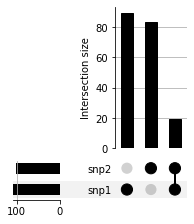

In [67]:
from upsetplot import UpSet
UpSet(test, subset_size='count').plot()
plt.show
plt.savefig("upset.pdf")

In [20]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("GM12878/190115_cas9enrich_mito1_multif5.gup5.rotM.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()


coverage at base 94 = 110380
coverage at base 11965 = 105811


read                                                  
      count unique                                   top freq
geno                                                         
--       19     19  c28d4740-3598-4648-8c15-95b95d34f788    1
-A       10     10  254a6509-b88e-4680-83b8-35cb295c2d8c    1
-C        1      1  8ee9330d-6a62-447a-8830-ee61c87959c1    1
-G     1128   1128  477d6da7-0527-47cd-937a-a1f9fc90c5d6    1
-T        2      2  c6f63ac5-8791-4ed0-8ee4-8429b477ca2c    1
A-        1      1  f2edbe60-c1eb-4f3f-852d-27739af4f8a0    1
AA        1      1  1e4e192b-c066-4289-9776-f43fb45312f2    1
AG      242    242  83ec4303-6d12-4d69-b050-c5d0fd395d3f    1
C-        4      4  c8e9a1ab-2cf6-4c31-bf7c-edfaf5fc5807    1
CA        4      4  e4735b5f-1e19-4385-87b0-9170e9f93164    1
CG      218    218  a1d7d525-4ea2-4edb-97f0-45cd35cdd61b    1
G-      961    961  c7530746-9e5d-4728-becd-c7f976c5e899    1
GA      670    670  e14298e6-2c26-4493-82fd-f64f84a10f28    1
GC       72     72  e0700c53-e1b4-410f-9373-6922d82d187a    1
GG    95721  95721  39e9cd96-8551-4a3e-a433-bfb54ca2bdaa    1
GT       77     77  651c605f-71c4-4429-8206-ae8bda001afa    1
T-        1      1  6a5e8589-5d31-41fd-8ef4-8174d1708034    1
TA        1      1  b7aae0bc-227d-43bd-ac30-4f2fadb652bc    1
TG       75     75  0116e948-81d4-4d5e-a681-7cfb898a11da    1

In [11]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/190226_UCLA_HD1.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 31971
coverage at base 11965 = 6958


read                                                  
     count unique                                   top freq
geno                                                        
--       1      1  2b94e9cf-cac4-49a2-b7fd-eaeb9d474a71    1
-G      44     44  7e1b9779-dd2b-42c7-ad29-aa6714255f9b    1
AG       9      9  39162c90-bc9b-4c0b-8b02-90fb104e0576    1
CG       9      9  c99f4b23-9f07-4239-b525-cedbe2fab56e    1
G-      15     15  3c7ca8b9-f1e4-4128-afb6-3735117d90f5    1
GA       4      4  00f1bbfb-6727-4c49-9f7d-408c26e2511e    1
GG    2069   2069  b57ce83e-7f29-4073-95f8-82e5df3621a1    1
GT       1      1  f4517a50-b18c-4cd6-a2d8-d7e6ed4a0732    1

In [12]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/190314_UCLA_old.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 63356
coverage at base 11965 = 59518


read                                                  
      count unique                                   top freq
geno                                                         
--       21     21  2b841124-8db0-4b32-9565-6b5c26f477f1    1
-A       14     14  7790b966-30b9-4ee9-b065-4973cc7c7d90    1
-C        3      3  81319c8f-4f13-459e-a542-8a1f04b55f0f    1
-G     1067   1067  edd9ea0b-d2fb-4ef4-9279-19b3cb7a59fe    1
-T        1      1  c19fb68d-875d-407c-889d-dd705ee2c599    1
A-        5      5  a78b0e59-139c-469a-9cbb-6b56dc9f35bf    1
AA        2      2  d8d392ff-5a10-4718-936a-552ee52c6016    1
AG      213    213  f5698bc2-d14f-4e9a-b33e-5ac861d2f1ea    1
C-        2      2  30e3105d-feff-43e4-a241-686ebf5434e7    1
CA        1      1  c180ec5b-071e-436b-b9c0-4b53f81b5aa4    1
CG      156    156  39d2d251-7421-4a75-bdcd-61b92bd7dcf0    1
G-      839    839  a77c034a-53db-4666-a819-33125a405d94    1
GA      410    410  b38a2102-c1a5-4d43-a734-bd680df8ab82    1
GC       97     97  647783dd-e4de-463b-88d5-ca7f2251ebaa    1
GG    49404  49404  c34198c4-114e-4841-ac1d-15ffce814d52    1
GT       88     88  c39a1e22-f254-4491-95de-840b7fbf5842    1
T-        2      2  1fce6e27-8bd7-4de0-9c83-3a8db99f63fb    1
TG       59     59  a5a22a47-5d1e-40ce-a93d-df924cc65178    1
TT        1      1  dc74056f-2e14-41ef-b129-7fcf5dc80305    1

In [13]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/190314_UCLA_young.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 108684
coverage at base 11965 = 95305


read                                                  
      count unique                                   top freq
geno                                                         
--       14     14  2ee2993c-1d70-4f51-8742-aa5a05d2ece0    1
-A        7      7  b7793349-5fb6-4928-a4da-66dff8490554    1
-C        1      1  75822757-8cf1-4b58-9309-859dd29e732e    1
-G     1246   1246  37252a93-0b5e-4afc-a2f1-9b8c94677920    1
-T        1      1  a371539f-4db9-47e5-8167-b92eee07a52a    1
A-        4      4  b21d62dd-fb6a-49de-9269-8cd47e5812e5    1
AA        2      2  0cb46d10-cda8-48cc-9692-1f362f3bf805    1
AC        1      1  d1561e25-6b77-49ba-aefc-c35c8e37a4b2    1
AG      258    258  3beba5ff-e3b2-4f39-8677-11c4df61286f    1
C-        2      2  9881f62c-48c8-4a4a-9077-da998bfa285f    1
CA        1      1  138f3737-5fda-4b56-8350-70dbc7043888    1
CG      216    216  3f19c25c-4a69-489d-88ef-a0cb04afc557    1
G-      911    911  7b649e13-b7e4-4000-9f78-dd86db465ddf    1
GA      522    522  c2989e3e-0054-433f-8dab-41377f00cacf    1
GC      102    102  22d216e6-0e56-42b8-9590-7c7c23a81e52    1
GG    75812  75812  eaa26c97-60c1-4f84-a686-fe8ad76476d6    1
GT       81     81  05223156-3110-4c9e-bcee-f663694bc863    1
T-        1      1  49270610-2f46-4895-a22a-cc9bc51c38c7    1
TA        1      1  08da06fe-6f62-4239-b6cd-62d2d1dece00    1
TG       72     72  a2d695a2-5cb6-4810-8619-0c3fc4f652ed    1
TT        1      1  c7cc8f74-5c39-4121-8314-7a1e08dca56e    1

In [14]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/190314_UCLA_young.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 108684
coverage at base 11965 = 95305


read                                                  
      count unique                                   top freq
geno                                                         
--       14     14  2ee2993c-1d70-4f51-8742-aa5a05d2ece0    1
-A        7      7  b7793349-5fb6-4928-a4da-66dff8490554    1
-C        1      1  75822757-8cf1-4b58-9309-859dd29e732e    1
-G     1246   1246  37252a93-0b5e-4afc-a2f1-9b8c94677920    1
-T        1      1  a371539f-4db9-47e5-8167-b92eee07a52a    1
A-        4      4  b21d62dd-fb6a-49de-9269-8cd47e5812e5    1
AA        2      2  0cb46d10-cda8-48cc-9692-1f362f3bf805    1
AC        1      1  d1561e25-6b77-49ba-aefc-c35c8e37a4b2    1
AG      258    258  3beba5ff-e3b2-4f39-8677-11c4df61286f    1
C-        2      2  9881f62c-48c8-4a4a-9077-da998bfa285f    1
CA        1      1  138f3737-5fda-4b56-8350-70dbc7043888    1
CG      216    216  3f19c25c-4a69-489d-88ef-a0cb04afc557    1
G-      911    911  7b649e13-b7e4-4000-9f78-dd86db465ddf    1
GA      522    522  c2989e3e-0054-433f-8dab-41377f00cacf    1
GC      102    102  22d216e6-0e56-42b8-9590-7c7c23a81e52    1
GG    75812  75812  eaa26c97-60c1-4f84-a686-fe8ad76476d6    1
GT       81     81  05223156-3110-4c9e-bcee-f663694bc863    1
T-        1      1  49270610-2f46-4895-a22a-cc9bc51c38c7    1
TA        1      1  08da06fe-6f62-4239-b6cd-62d2d1dece00    1
TG       72     72  a2d695a2-5cb6-4810-8619-0c3fc4f652ed    1
TT        1      1  c7cc8f74-5c39-4121-8314-7a1e08dca56e    1

In [15]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/210506_y3_UCLA.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 13094
coverage at base 11965 = 3693


read                                                  
     count unique                                   top freq
geno                                                        
--       2      2  7aaa30ff-54d9-465b-a504-6db04766f416    1
-A       1      1  68cb0e16-8604-4569-8fa4-d5f0b50e6cf2    1
-G      81     81  69162c04-b289-4249-a006-6371ec6791de    1
AG      20     20  0efe15de-f1e3-4d3b-8de3-bf02a3473ed0    1
CG      12     12  ecd6543c-cd69-4a73-ae6f-d167e86a2226    1
G-      45     45  0dfa442f-21c4-43fc-a8b5-1808c0f25a91    1
GA      23     23  e3262582-6218-4161-b07e-6f211cc13c21    1
GG    2880   2880  4cfb7279-ccfe-4634-8a7e-8854a9ad45e3    1
GT       1      1  74bc276b-e9ef-4868-a562-2ec3080157c4    1
TG       1      1  783b676f-c4f0-4e6f-9e1f-68f6ccae2cfa    1

In [16]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/old3_UCLA_merge.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 90930
coverage at base 11965 = 37474


read                                                  
      count unique                                   top freq
geno                                                         
--        8      8  05dce4dc-4833-49ca-a467-052db1d87524    1
-A        9      9  aeb11513-1cee-42b7-9507-4bc969a17d6e    1
-G      398    398  2141c9ad-138d-4f4e-9e23-9d65bd05750f    1
-T        1      1  d85362ae-4a36-4b5f-9885-74d3eefaee70    1
AA        1      1  21ed31a2-c4e6-47bb-bcf1-576719c11a04    1
AG      110    110  3750778a-c7a6-4fbb-8325-2201d4f9dfc9    1
CG      113    113  a58011cd-13f8-4ca0-8fae-bda322bfa9d5    1
G-      368    368  88cd95b5-2dfb-4ea4-92d8-ac57f5062737    1
GA      237    237  da6137e8-4bef-4391-816f-fbe5ba4ce2e9    1
GC       13     13  87582883-0e49-4b91-98a2-413eab2afdf4    1
GG    21451  21451  482be819-6a3f-4d09-9adf-ce4158c1fa93    1
GT       28     28  87bdf581-87a7-4ac5-aa37-d96e4fadfdcb    1
TG       12     12  36a899d0-932b-46f0-bc19-bdc7cb3536a2    1

In [17]:
myloc=[94,11965]
bammy=pysam.AlignmentFile("Muscle/bam/old4_UCLA_merge.rot.bam", "rb")

mapped=bammy.pileup("chrM_rot", myloc[0], myloc[1],min_base_quality=0, max_depth=1000000)
readvariants=dict()
for pileupcolumn in mapped:
    if pileupcolumn.pos in myloc:
        print("coverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if pileupread.is_del:
                base="-" 
            else:
                base=pileupread.alignment.query_sequence[pileupread.query_position]
            if readname in readvariants:
                readvariants[readname]=readvariants[readname]+base
            else:
                readvariants[readname]=base

readvariants={key: value for (key, value) in readvariants.items() if len(value) == len(myloc)}


geno=pd.DataFrame.from_dict(readvariants, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

coverage at base 94 = 25933
coverage at base 11965 = 13890


read                                                  
      count unique                                   top freq
geno                                                         
--        5      5  b09454c5-b0e9-455f-a625-f097ef9d9a9d    1
-A        3      3  d080722b-d75e-44bf-af41-a74013a446c8    1
-G      251    251  1e92f113-3b3f-4eea-a3e9-621b71df8355    1
A-        3      3  be652b4d-4f52-4e9e-8cdc-204f18ce4ef2    1
AA        1      1  86654cd1-9254-49d9-8b53-63d26866eac9    1
AG       69     69  fa01ee8a-aebb-408d-95f0-7292aaed6dba    1
C-        2      2  43ecf77a-0099-4123-a328-16d4caeef945    1
CA        1      1  4a4c6c46-4e0b-4ce4-824d-f341a9a1d414    1
CG       52     52  c79dd195-4e7e-4745-b28c-9e7c675ed7ac    1
G-      205    205  2a462d40-ea23-4af2-b525-af94f96ee7d7    1
GA      112    112  474d9c73-3af7-4ba6-ad17-09041cee123c    1
GC        3      3  0b9111ba-0b9e-4387-a3fa-d2cb70e37674    1
GG    11001  11001  85e6d021-8163-435f-8290-76bd07f64ef0    1
GT       14     14  43d7a55f-90a7-40a5-b785-d9fa4f836bf1    1
TG        8      8  d0dc6b6b-9697-493c-afed-af926ceed740    1

In [ ]:
#Now load in illumina data, look at % of each snp
cd Timp_data/HV/illumina

In [ ]:
ref="/Users/amyvandiver/Box/Nanopore/TimpLab/Ref/GRCh38.primary_assembly.genome.fa"
fq1="mito_S1_L001_R1_001.fastq"
fq2="mito_S1_L001_R2_001.fastq"

In [ ]:
!echo $(( $(wc -l < $fq1) / 4 )) reads
!echo $(( $(wc -l < $fq2) / 4 )) reads

In [ ]:
!bwa index {ref}

In [ ]:
!bwa mem {ref} {fq1} {fq2}| samtools view -bS -uF 4 | samtools sort -o mito_S1.bam
!samtools index mito_S1.bam
!samtools idxstats mito_S1.bam

In [ ]:
bam= "mito_S1.bam"

In [ ]:
import pysam
import pandas as pd

In [ ]:
snp1=[1641]
snp2=[13512]

In [ ]:
samfile = pysam.AlignmentFile(bam, "rb" )
variants1=dict()
for pileupcolumn in samfile.pileup("chrM",max_depth=1000000):
    if pileupcolumn.pos in snp1:
        print ("\ncoverage at base %s = %s" %
           (pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if not pileupread.is_del and not pileupread.is_refskip:
                # query position is None if is_del or is_refskip is set.
                base=pileupread.alignment.query_sequence[pileupread.query_position]
                variants1[readname]=base
samfile.close()

geno=pd.DataFrame.from_dict(variants1, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()

In [ ]:
geno.to_csv("geno_1642.csv",index=False)

In [ ]:
samfile = pysam.AlignmentFile(bam, "rb" )
variants1=dict()
for pileupcolumn in samfile.pileup("chrM",max_depth=25000):
    if pileupcolumn.pos in snp2:
        print ("\ncoverage at base %s = %s" %
           (pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            readname=pileupread.alignment.query_name
            if not pileupread.is_del and not pileupread.is_refskip:
                # query position is None if is_del or is_refskip is set.
                base=pileupread.alignment.query_sequence[pileupread.query_position]
                variants1[readname]=base
samfile.close()

geno=pd.DataFrame.from_dict(variants1, orient='index',columns=["geno"])
geno.index.name = "read"
geno.reset_index(inplace=True)
geno.groupby("geno").describe()


In [ ]:
geno.to_csv("geno_13513.csv",index=False)